In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from RoomObjects2 import Room, Object

In [2]:
class Object:
    
    def __init__(self, name, position, width, length, orientation = 0):
        self.name = name
        self.position = position
        self.width = width
        self.length = length
        self.orientation = orientation # in radians
        
class Room:

    def __init__(self, width, length):
        self.width = width
        self.length = length
        self.fixed_objects = []
        self.moving_objects = []
        self.center = (width/2, length/2)

    def find(self, name):
        for obj in self.fixed_objects + self.moving_objects:
            if obj.name == name:
                return obj
        return None
    
    def find_all(self, name):
        objects = []
        for obj in self.fixed_objects + self.moving_objects:
            if obj.name == name:
                objects.append(obj)
        return objects
    
    def count(self, name):
        counter = 0
        for obj in self.fixed_objects + self.moving_objects:
            if obj.name == name:
                counter += 1
        return counter
    
    def boundary_constraint(self, x, y, theta, object, weight = 1):

        w, l = object.width, object.length
        W, L = self.width, self.length
        
        TR = (x + w/2 * np.cos(theta) - l/2 * np.sin(theta), y + w/2 * np.sin(theta) + l/2 * np.cos(theta))
        BR = (x + w/2 * np.cos(theta) + l/2 * np.sin(theta), y + w/2 * np.sin(theta) - l/2 * np.cos(theta))
        TL = (x - w/2 * np.cos(theta) - l/2 * np.sin(theta), y - w/2 * np.sin(theta) + l/2 * np.cos(theta))
        BL = (x - w/2 * np.cos(theta) + l/2 * np.sin(theta), y - w/2 * np.sin(theta) - l/2 * np.cos(theta))

        value = 0

        for corner in [TR, BR, TL, BL]:

            value += np.minimum(corner[0], 0)**2 + np.maximum(corner[0] - W, 0)**2 + np.minimum(corner[1], 0)**2 + np.maximum(corner[1] - L, 0)**2
            
        return weight * value

    
    def intersection_constraint(self, x, y, theta, object, weight = 2):

        w, l = object.width, object.length

        TRi = (x + w/2 * np.cos(theta) - l/2 * np.sin(theta), y + w/2 * np.sin(theta) + l/2 * np.cos(theta))
        BRi = (x + w/2 * np.cos(theta) + l/2 * np.sin(theta), y + w/2 * np.sin(theta) - l/2 * np.cos(theta))
        TLi = (x - w/2 * np.cos(theta) - l/2 * np.sin(theta), y - w/2 * np.sin(theta) + l/2 * np.cos(theta))
        BLi = (x - w/2 * np.cos(theta) + l/2 * np.sin(theta), y - w/2 * np.sin(theta) - l/2 * np.cos(theta))

        Ai = [(np.cos(theta), np.sin(theta)), (-np.sin(theta), np.cos(theta))]
        corners_i = [TRi, BRi, TLi, BLi]

        penalty = 0

        def projection(axis, corners):
            
            minimum = 100
            maximum = -100
            for corner in corners:
                proj = corner[0] * axis[0] + corner[1] * axis[1]
                minimum = np.minimum(minimum, proj)
                maximum = np.maximum(maximum, proj)
            
            return (minimum, maximum)


        for obj in self.fixed_objects + self.moving_objects:
            if obj != object:
                xj, yj = obj.position
                wj, lj = obj.width, obj.length
                theta_j = obj.orientation

                TRj = (xj + wj/2 * np.cos(theta_j) - lj/2 * np.sin(theta_j), yj + wj/2 * np.sin(theta_j) + lj/2 * np.cos(theta_j))
                BRj = (xj + wj/2 * np.cos(theta_j) + lj/2 * np.sin(theta_j), yj + wj/2 * np.sin(theta_j) - lj/2 * np.cos(theta_j))
                TLj = (xj - wj/2 * np.cos(theta_j) - lj/2 * np.sin(theta_j), yj - wj/2 * np.sin(theta_j) + lj/2 * np.cos(theta_j))
                BLj = (xj - wj/2 * np.cos(theta_j) + lj/2 * np.sin(theta_j), yj - wj/2 * np.sin(theta_j) - lj/2 * np.cos(theta_j))
                
                Aj = [(np.cos(theta_j), np.sin(theta_j)), (-np.sin(theta_j), np.cos(theta_j))]
                corners_j = [TRj, BRj, TLj, BLj]

                overlaps = []
                for axis in Ai + Aj:
                    min_i, max_i = projection(axis, corners_i)
                    min_j, max_j = projection(axis, corners_j)

                    # Calculate the overlap on this axis
                    overlaps += [max(0, min(max_i, max_j) - max(min_i, min_j))]
                    
                if np.all(overlaps) > 0:
                    penalty += weight*np.prod(overlaps)
        
        return penalty
    
    def add(self, list_of_funcs, figsize = (12, 8)):

        fig, axes = plt.subplots(1, 2, figsize = figsize)

        for ax in axes:
            ax.set_xlim(-1, self.width + 1)
            ax.set_ylim(-1, self.length + 1)
            ax.set_aspect('equal')
            ax.grid(linestyle = '--')

            rect = patches.Rectangle((0, 0), self.width, self.length, linewidth=2, edgecolor='black', facecolor='none')
            ax.add_patch(rect)

        # Draw the objects
        if self.moving_objects:
            for obj in self.moving_objects:
                rectangle = patches.Rectangle(obj.position  - np.array([obj.width/2, obj.length/2]), obj.width, obj.length, linewidth=2, edgecolor='none', facecolor='none', angle=np.rad2deg(obj.orientation), rotation_point='center')
                axes[0].add_patch(rectangle)
                line, = plt.plot([], [], label=obj.name)  # Create an invisible line
                rectangle.set_edgecolor(line.get_color())  # Use the line's color for the rectangle
                axes[0].text(obj.position[0], obj.position[1], obj.name, fontsize=10)

        if self.fixed_objects:
            for obj in self.fixed_objects:
                rect = patches.Rectangle(obj.position - np.array([obj.width/2, obj.length/2]), obj.width, obj.length, linewidth=5, edgecolor='r', facecolor='none')
                axes[0].add_patch(rect)
                axes[0].text(obj.position[0] + 0.05, obj.position[1] + 0.05, obj.name, fontsize=10)

        for func in list_of_funcs:
            func(self)
        
        if self.moving_objects:
            for obj in self.moving_objects:
                rectangle = patches.Rectangle(obj.position  - np.array([obj.width/2, obj.length/2]), obj.width, obj.length, linewidth=2, edgecolor='none', facecolor='none', angle=np.rad2deg(obj.orientation), rotation_point='center')
                axes[1].add_patch(rectangle)
                line, = plt.plot([], [], label=obj.name)  # Create an invisible line
                rectangle.set_edgecolor(line.get_color())  # Use the line's color for the rectangle
                axes[1].text(obj.position[0], obj.position[1], obj.name, fontsize=10)

        if self.fixed_objects:
            for obj in self.fixed_objects:
                rect = patches.Rectangle(obj.position - np.array([obj.width/2, obj.length/2]), obj.width, obj.length, linewidth=5, edgecolor='r', facecolor='none')
                axes[1].add_patch(rect)
                axes[1].text(obj.position[0] + 0.05, obj.position[1] + 0.05, obj.name, fontsize=10)

        return 
            
    def draw(self):
        fig, ax = plt.subplots()
        ax.set_xlim(-1, self.width + 1)
        ax.set_ylim(-1, self.length + 1)
        ax.set_aspect('equal')
        ax.grid(linestyle = '--')

        # Draw the room
        rect = patches.Rectangle((0, 0), self.width, self.length, linewidth=2, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

        # Draw the objects
        if self.moving_objects:
            for obj in self.moving_objects:
                rectangle = patches.Rectangle(obj.position  - np.array([obj.width/2, obj.length/2]), obj.width, obj.length, linewidth=2, edgecolor='none', facecolor='none', angle=np.rad2deg(obj.orientation), rotation_point='center')
                ax.add_patch(rectangle)
                line, = plt.plot([], [], label=obj.name)  # Create an invisible line
                rectangle.set_edgecolor(line.get_color())  # Use the line's color for the rectangle
                ax.text(obj.position[0], obj.position[1], obj.name, fontsize=10)
        
        if self.fixed_objects:
            for obj in self.fixed_objects:
                rect = patches.Rectangle(obj.position - np.array([obj.width/2, obj.length/2]), obj.width, obj.length, linewidth=5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(obj.position[0] + 0.05, obj.position[1] + 0.05, obj.name, fontsize=10)

        plt.show()
        return 


In [7]:
def add_bed(room, disp = False):

    bed = room.find('bed')
    if bed == None:
        print("There is no bed in this room. Adding one now.")
        room.moving_objects += [Object('bed', room.center, 1.91, 1.37, 0)]
        bed = room.find('bed')
    
    doors = room.find_all('door')
    windows = room.find_all('window')

    W, L = room.width, room.length
    w = bed.width
    l = bed.length
    nw = 0.8 # nightstand width

    def objective(position):
        
        x, y, theta = position
        out = 0

        if np.cos(theta) >= 0:
            TL = (x - w/2 * np.cos(theta) - l/2 * np.sin(theta), y - w/2 * np.sin(theta) + l/2 * np.cos(theta))
            BL = (x - w/2 * np.cos(theta) + l/2 * np.sin(theta), y - w/2 * np.sin(theta) - l/2 * np.cos(theta))
            back_x, back_y = ((TL[0] + BL[0])/2, (TL[1] + BL[1])/2)
            corner1, corner2 = TL, BL
        else:
            TR = (x + w/2 * np.cos(theta) - l/2 * np.sin(theta), y + w/2 * np.sin(theta) + l/2 * np.cos(theta))
            BR = (x + w/2 * np.cos(theta) + l/2 * np.sin(theta), y + w/2 * np.sin(theta) - l/2 * np.cos(theta))
            back_x, back_y = ((TR[0] + BR[0])/2, (TR[1] + BR[1])/2)
            corner1, corner2 = TR, BR

        ## Constraint: Bed against wall
        wall_distances = np.array([0.0, 0, 0, 0])
        back_points = [corner1, corner2]
        for i in range(2):
            wall_distances += np.array([back_points[i][0], W - back_points[i][0], back_points[i][1], L - back_points[i][1]])

        d_wall = np.min(wall_distances**2)
        out += d_wall

        ## Constraints: Bed away from doors and windows
        d_door = 0
        d_window = 0
        for door in doors:
            d_door += np.sqrt((x - door.position[0])**2 + (y - door.position[1])**2)
        for window in windows:
            d_window += np.sqrt((x - window.position[0])**2 + (y - window.position[1])**2)

        if len(doors) != 0:
            d_door = 1/d_door
        if len(windows) != 0:
            d_window = 1/d_window

        out += d_door + d_window

        ## Constraint: Bed centered on a wall 
        d_north = np.sqrt((back_x - W/2)**2 + (back_y)**2)
        d_south = np.sqrt((back_x - W/2)**2 + (back_y - (L))**2)
        d_east = np.sqrt((back_x - (W - w/2))**2 + (back_y - L/2)**2)
        d_west = np.sqrt((back_x - w/2)**2 + (back_y - L/2)**2)

        out += np.min([d_north, d_south, d_east, d_west])

        ## Constraint: Enough Space for Nightstands
        vals = [corner1, corner2]
        output_vals = [0, 0, 0, 0]
        for i in range(2):
            val = np.array([vals[i][0], vals[i][1]])

            ## Check if we need to consider the door. 

            left = [0, val[1] + (val[0])*np.tan(theta)]
            right = [W, val[1] + (W - val[0])*np.tan(theta + np.pi/2)]
            bottom = [val[0] + val[1]*np.clip(np.tan(theta), -1, 1), 0]
            top = [val[0] + (val[1] - L)* np.clip(np.tan(theta), -1, 1), L]

            dist_bottom = np.linalg.norm(bottom - val)
            dist_top = np.linalg.norm(top - val)
            dist_left = np.linalg.norm(left - val)
            dist_right = np.linalg.norm(right - val)

            if min(corner1[0], corner2[0]) < bottom[0] < max(corner1[0], corner2[0]):
                dist_bottom *= -1  
            if min(corner1[0], corner2[0]) < top[0] < max(corner1[0], corner2[0]):
                dist_top *= -1
            if min(corner1[0], corner2[0]) < left[0] < max(corner1[0], corner2[0]):
                dist_left *= -1
            if min(corner1[0], corner2[0]) < right[0] < max(corner1[0], corner2[0]):
                dist_right *= -1
            
            dists = [dist_bottom, dist_top, dist_left, dist_right]
            dists.sort()
            output_vals[2*i:2*i + 2] = dists[:2]
            for j in range(2*i, 2*i + 2):
                if output_vals[j] < nw:
                    output_vals[j] = 2*(output_vals[j] - nw)**2
                else:
                    output_vals[j] = 0
            
        c_nightstands = np.sum(output_vals)

        out = d_wall + np.min([d_north, d_south, d_east, d_west]) + c_nightstands
        if len(doors) !=0:
            out += 1/d_door
        if len(windows) != 0:
            out += 1/d_window
        
        out += room.boundary_constraint(x, y, theta, bed, weight = 10) + room.intersection_constraint(x, y, theta, bed, weight = 10)

        return out
        
    res = minimize(objective, [bed.position[0], bed.position[1], bed.orientation], method='Nelder-Mead')
    bed.position = res.x[:2]
    bed.orientation = res.x[2]

    if disp:
        room.draw()

    return

There is no bed in this room. Adding one now.
0.0
0
0.030557460434222618


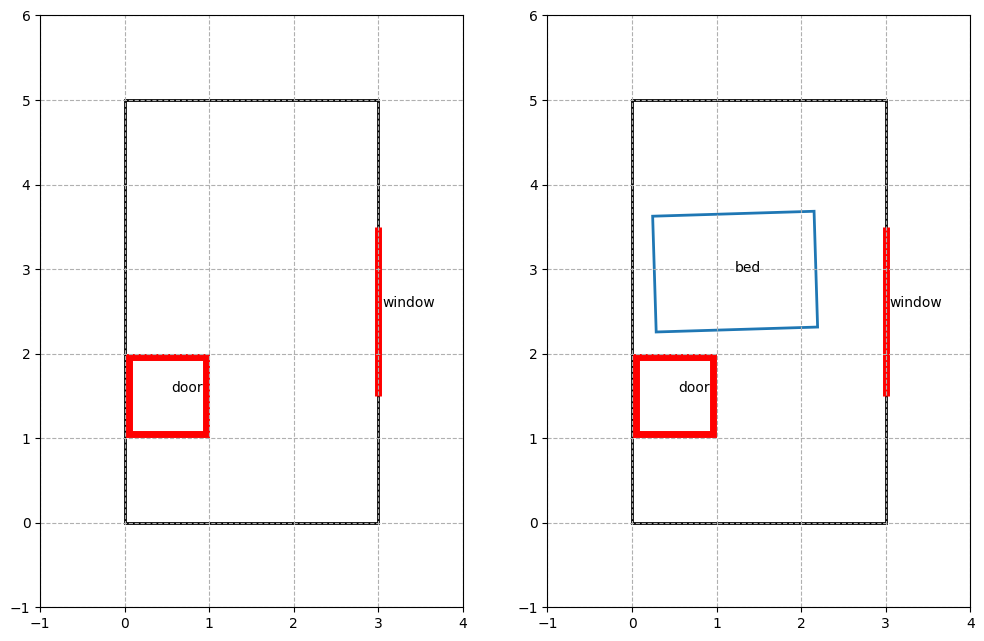

In [8]:
room = Room(3, 5)
room.fixed_objects = [Object('door', (0.5, 1.5), 0.91, 0.91), Object('window', (3, 2.5), 0, 2)]
room.add([add_bed])

bed = room.find('bed')
print(room.boundary_constraint(bed.position[0], bed.position[1], bed.orientation, bed, weight = 100))
print(room.intersection_constraint(bed.position[0], bed.position[1], bed.orientation, bed, weight = 2))
print(bed.orientation)

There is no bed in this room. Adding one now.
0.0
0
-0.0003109762488608316


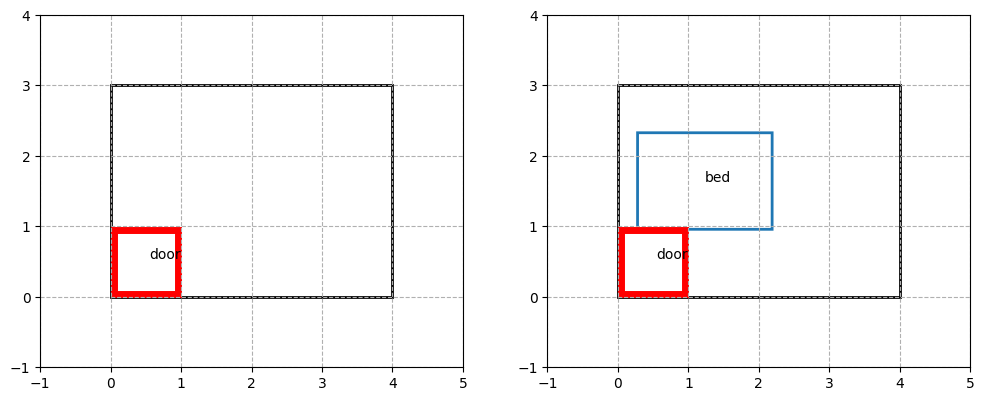

In [8]:
room = Room(4, 3)
room.fixed_objects = [Object('door', (0.5, 0.5), 0.91, 0.91)]#, Object('window', (4, 2.2), 0, 1)]#, Object('window', (0.5, 3), 1, 0)]

room.add([add_bed])#, add_nightstand, add_nightstand, add_wardrobe])
bed = room.find('bed')
print(room.boundary_constraint(bed.position[0], bed.position[1], bed.orientation, bed, weight = 100))
print(room.intersection_constraint(bed.position[0], bed.position[1], bed.orientation, bed, weight = 10))
print(bed.orientation)

In [ ]:
def add_nightstand(room, disp = False):

    def reflect(point, center, angle):

        x_prime, y_prime = point - center
        x_prime, y_prime = np.array([[np.cos(angle), np.sin(angle)], [np.sin(angle), -np.cos(angle)]]) @ np.array([x_prime, y_prime])
        x_prime, y_prime = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]) @ np.array([x_prime, y_prime])

        return (x_prime + center[0], y_prime + center[1])

    bed = room.find('bed')
    if bed == None: 
        print("There is no bed in this room. You should add a bed before adding nightstands.")
        return

    counter = room.count('nightstand')
    if counter >= 2:
        print("There are enough nightstands in this room. ")
        return
    
    elif counter == 1:
        print("Adding a second nightstand.")
        nightstand1 = room.find('nightstand')
        nightstand = Object('nightstand', room.center, 0.5, 0.5)
        room.moving_objects += [nightstand]

    elif counter == 0:
        print("There are no nightstands in this room. Adding one now.")
        nightstand = Object('nightstand', room.center, 0.5, 0.5)
        room.moving_objects += [nightstand]
    
    def objective(position):

        x, y, theta = position
        w, l = nightstand.width, nightstand.length
        W, L = room.width, room.length

        if np.cos(theta) >= 0:
            TL = (x - w/2 * np.cos(theta) - l/2 * np.sin(theta), y - w/2 * np.sin(theta) + l/2 * np.cos(theta))
            BL = (x - w/2 * np.cos(theta) + l/2 * np.sin(theta), y - w/2 * np.sin(theta) - l/2 * np.cos(theta))
            back_x, back_y = ((TL[0] + BL[0])/2, (TL[1] + BL[1])/2)
        else:
            TR = (x + w/2 * np.cos(theta) - l/2 * np.sin(theta), y + w/2 * np.sin(theta) + l/2 * np.cos(theta))
            BR = (x + w/2 * np.cos(theta) + l/2 * np.sin(theta), y + w/2 * np.sin(theta) - l/2 * np.cos(theta))
            back_x, back_y = ((TR[0] + BR[0])/2, (TR[1] + BR[1])/2)

        ## Constraint: Bed against wall
        wall_distances = [back_x, W - back_x, back_y, L - back_y]
        d_wall = np.min(wall_distances)

        d_bed = np.sqrt((x - bed.position[0])**2 + (y - bed.position[1])**2)
        d_orientation = (theta - bed.orientation)**2
        out = room.boundary_constraint(x, y, nightstand, weight = 1000) + room.intersection_constraint(x, y, nightstand, weight = 50) + d_bed + d_wall + d_orientation

        # If second nighstand, add a penalty for lack of symmetry 
        if counter == 1:

            reflected = reflect(nightstand1.position, bed.position, bed.orientation)
            out += (x - reflected[0])**2 + (y - reflected[1])**2 + (theta - nightstand1.orientation)**2

        return out
    
    res = minimize(objective, [nightstand.position[0], nightstand.position[1], nightstand.orientation], method='Nelder-Mead')
    nightstand.position = res.x[:2]
    nightstand.orientation = res.x[2]
    
    if disp:
        room.draw()

    return